In [44]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import os
from sklearn.metrics import mean_squared_error
import datetime
import tensorflow as tf
from tensorflow.contrib import learn
from tensorflow.python.ops import rnn, rnn_cell
import matplotlib.pyplot as plt
import cPickle
import gzip
import math
%matplotlib inline

# 提取主力合约数据，已经加入了MA、EMA、MACD、布林线等指标

In [45]:
# 提取主力合约数据
path = '/home/chocolate/LSTM-source/'
data = pd.read_csv(path + 'data_added_features.csv')
data=data.ix[:,3:]
data = data.fillna(0)
data
# data['RaiseDown'] = (data['Latestprice'] - data['First.Latestprice'])/data['First.Latestprice']

,Latestprice,MaxPrice,MinPrice,Stockup,Turnover,Position,Volume,First.Latestprice,Last.Buy1price,Last.Buy1quantity,...,Vol_EMA_12,Vol_EMA_26,Dis_Vol_EMA5_26,DIFF_12_26,DEA_12_26,MACD,boll_up,boll_down,b_index,channel_width
0,3640.4,3646.0,3640.2,-63,115844340,28315,106,3644.8,3640.2,2,...,106.000000,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3625.8,3641.4,3624.4,-79,228902820,28236,210,3640.4,3625.0,4,...,162.333333,160.000000,8.400000,-0.327564,-0.181980,-0.291168,0.000000,0.000000,0.000000,0.000000
2,3618.8,3626.8,3612.6,-110,301745580,28126,278,3625.4,3619.2,1,...,207.478060,202.396254,17.919535,-0.634451,-0.367419,-0.534064,0.000000,0.000000,0.000000,0.000000
3,3617.0,3620.2,3616.0,-81,162817740,28045,150,3618.8,3616.8,5,...,189.334483,187.748551,3.359141,-0.823469,-0.521908,-0.603123,0.000000,0.000000,0.000000,0.000000
4,3618.0,3618.8,3613.0,-66,143205060,27979,132,3616.8,3618.0,2,...,173.756909,174.820232,-6.403171,-0.869050,-0.625175,-0.487751,0.000000,0.000000,0.000000,0.000000
5,3621.0,3621.6,3618.0,-47,111857580,27931,103,3618.2,3621.0,1,...,156.559257,160.435213,-15.922431,-0.751834,-0.659506,-0.184655,0.000000,0.000000,0.000000,0.000000
6,3614.2,3621.4,3614.2,-46,120504420,27885,111,3621.0,3612.8,2,...,146.392868,151.643416,-18.996015,-0.971763,-0.738530,-0.466465,0.000000,0.000000,0.000000,0.000000
7,3601.2,3615.6,3600.0,-98,372121500,27787,344,3614.2,3601.0,1,...,187.630431,182.636828,23.321935,-1.721885,-0.974849,-1.494072,0.000000,0.000000,0.000000,0.000000
8,3602.2,3608.6,3600.4,-68,195712320,27719,181,3601.2,3602.2,2,...,186.318696,182.394214,15.022770,-2.165518,-1.249899,-1.831237,0.000000,0.000000,0.000000,0.000000
9,3604.6,3608.4,3599.0,-70,198897300,27649,184,3602.0,3603.4,1,...,185.879304,182.615797,10.249933,-2.325090,-1.490804,-1.668572,0.000000,0.000000,0.000000,0.000000


### 加入后面几分钟的预测指标

In [46]:
# 为主力合约数据添加两个特征：平均价和下一分钟涨跌幅
# 其中，平均价为当前分钟的四个价格的平均值
# 下一分钟的涨跌幅为（下一分钟平均价 - 当前分钟平均价）/当前分钟平均价
data['MeanPrice'] = (data['Latestprice'] + data['First.Latestprice'] +data['MaxPrice']+data['MinPrice'])/4
ser_1 = data['MeanPrice'][1:]
ser_1.index = range(len(ser_1))
ser1 = data['MeanPrice'][:-1]
ser1.index = range(len(ser1))
data['RaiseDown_1'] = (ser_1 -ser1)/ser1
# 同理，计算当前分钟的后2分钟、3分钟、4分钟、5分钟的涨跌幅
ser_2 = data['MeanPrice'][2:]
ser_2.index = range(len(ser_2))
ser2 = data['MeanPrice'][:-2]
ser2.index = range(len(ser2))
data['RaiseDown_2'] = (ser_2 -ser2)/ser2

ser_3 = data['MeanPrice'][3:]
ser_3.index = range(len(ser_3))
ser3 = data['MeanPrice'][:-3]
ser3.index = range(len(ser3))
data['RaiseDown_3'] = (ser_3 -ser3)/ser3

ser_4 = data['MeanPrice'][4:]
ser_4.index = range(len(ser_4))
ser4 = data['MeanPrice'][:-4]
ser4.index = range(len(ser4))
data['RaiseDown_4'] = (ser_4 -ser4)/ser4

ser_5 = data['MeanPrice'][5:]
ser_5.index = range(len(ser_5))
ser5 = data['MeanPrice'][:-5]
ser5.index = range(len(ser5))
data['RaiseDown_5'] = (ser_5 -ser5)/ser5
data = data.fillna(0)

In [47]:
# 添加下一分钟的MA5、MA12、MA26、上轨线、下轨线指标
ser_1 = data['MA_5'][1:]
ser_1.index = range(len(ser_1))
data['MA_5_PRED'] = ser_1

ser_2 = data['MA_12'][1:]
ser_2.index = range(len(ser_2))
data['MA_12_PRED'] = ser_2

ser_3 = data['MA_26'][1:]
ser_3.index = range(len(ser_3))
data['MA_26_PRED'] = ser_3

ser_4 = data['boll_up'][1:]
ser_4.index = range(len(ser_4))
data['boll_up_PRED'] = ser_4

ser_5 = data['boll_down'][1:]
ser_5.index = range(len(ser_5))
data['boll_down_PRED'] = ser_5
data = data.fillna(0)
data

,Latestprice,MaxPrice,MinPrice,Stockup,Turnover,Position,Volume,First.Latestprice,Last.Buy1price,Last.Buy1quantity,...,RaiseDown_1,RaiseDown_2,RaiseDown_3,RaiseDown_4,RaiseDown_5,MA_5_PRED,MA_12_PRED,MA_26_PRED,boll_up_PRED,boll_down_PRED
0,3640.4,3646.0,3640.2,-63,115844340,28315,106,3644.8,3640.2,2,...,-0.002704,-0.006026,-0.006822,-0.007192,-0.006355,0.00,0.000000,0.000000,0.000000,0.000000
1,3625.8,3641.4,3624.4,-79,228902820,28236,210,3640.4,3625.0,4,...,-0.003331,-0.004129,-0.004500,-0.003661,-0.004211,0.00,0.000000,0.000000,0.000000,0.000000
2,3618.8,3626.8,3612.6,-110,301745580,28126,278,3625.4,3619.2,1,...,-0.000801,-0.001174,-0.000331,-0.000884,-0.003632,0.00,0.000000,0.000000,0.000000,0.000000
3,3617.0,3620.2,3616.0,-81,162817740,28045,150,3618.8,3616.8,5,...,-0.000373,0.000470,-0.000083,-0.002833,-0.004118,3624.00,0.000000,0.000000,0.000000,0.000000
4,3618.0,3618.8,3613.0,-66,143205060,27979,132,3616.8,3618.0,2,...,0.000843,0.000290,-0.002461,-0.003747,-0.003636,3620.12,0.000000,0.000000,0.000000,0.000000
5,3621.0,3621.6,3618.0,-47,111857580,27931,103,3618.2,3621.0,1,...,-0.000553,-0.003301,-0.004586,-0.004476,-0.004614,3617.80,0.000000,0.000000,0.000000,0.000000
6,3614.2,3621.4,3614.2,-46,120504420,27885,111,3621.0,3612.8,2,...,-0.002750,-0.004036,-0.003925,-0.004063,-0.003690,3614.28,0.000000,0.000000,0.000000,0.000000
7,3601.2,3615.6,3600.0,-98,372121500,27787,344,3614.2,3601.0,1,...,-0.001289,-0.001178,-0.001317,-0.000942,-0.000956,3611.32,0.000000,0.000000,0.000000,0.000000
8,3602.2,3608.6,3600.4,-68,195712320,27719,181,3601.2,3602.2,2,...,0.000111,-0.000028,0.000347,0.000333,0.000500,3608.64,0.000000,0.000000,0.000000,0.000000
9,3604.6,3608.4,3599.0,-70,198897300,27649,184,3602.0,3603.4,1,...,-0.000139,0.000236,0.000222,0.000389,0.000444,3604.92,0.000000,0.000000,0.000000,0.000000


In [48]:
data_new = data.drop(data.columns[36:],axis = 1)
data_new
data_new_array = np.array(data_new)
data_new_array.shape

(35758, 36)

## 对数据进行标准化

In [49]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data_new_array = min_max_scaler.fit_transform(data_new_array)
data_new_array

array([[ 1.        ,  1.        ,  1.        , ...,  0.21249949,
         0.        ,  1.        ],
       [ 0.98349537,  0.9947952 ,  0.98259529, ...,  0.21249949,
         0.        ,  0.98885873],
       [ 0.97558218,  0.97827563,  0.96959683, ...,  0.21249949,
         0.        ,  0.97517249],
       ..., 
       [ 0.61994122,  0.61620276,  0.62987442, ...,  0.1961128 ,
         0.00942811,  0.61814274],
       [ 0.62061949,  0.61461869,  0.6294338 , ...,  0.28687739,
         0.00903733,  0.61735098],
       [ 0.62084558,  0.61552387,  0.62965411, ...,  0.34779494,
         0.00939723,  0.61791653]])

## 生成5分钟的时间序列，变为3维数组

In [50]:
seq_new_5 = []
for j in range(len(data_new_array)):
    if j+5 < len(data_new_array):
        seq_new_5.append(data_new_array[j:j+5])
seq_new_5 = np.array(seq_new_5)
seq_new_5.shape

(35753, 5, 36)

# 进行涨跌情况的分类

## 提取训练集、测试集。根据下一分钟的涨跌幅分别打标签，分为五类（通过调整RaiseDown_可改变预测时长）

In [44]:
# 取前面10000个数据作为训练集
# 前面的数据点因有na值填充，会对准确性造成一定影响，因此从第1000个点开始
train_data = seq_new_5[1000:11000]
train_data.shape

(10000, 5, 32)

In [160]:
data1 = data[1000:11000]
train_label = []
for i in data1['RaiseDown_5']:
    if i > 0.002:
        train_label.append([1,0,0,0,0])   #大涨
    elif i > 0.0005:
        train_label.append([0,1,0,0,0])   #小涨
    elif i> -0.0005: 
        train_label.append([0,0,1,0,0])   #平稳
    elif i > -0.002:
        train_label.append([0,0,0,1,0])   #小跌
    else:
        train_label.append([0,0,0,0,1])   #大跌
train_label = np.array(train_label)
train_label.shape

(10000, 5)

In [161]:
# 统计五类情况各自的数量
train_label_list = train_label.tolist()
print u'大涨：',train_label_list.count([1,0,0,0,0])
print u'小涨：',train_label_list.count([0,1,0,0,0])
print u'平稳：',train_label_list.count([0,0,1,0,0])
print u'小跌：',train_label_list.count([0,0,0,1,0])
print u'大跌：',train_label_list.count([0,0,0,0,1])

大涨： 1775
小涨： 2125
平稳： 1880
小跌： 2455
大跌： 1765


# 取后面2000个分钟数据作为测试集

In [162]:
test_data = seq_new_5[12000:14000]
test_data = np.array(test_data)
test_data.shape

(2000, 5, 32)

In [163]:
data2 = data[12000:14000]
test_label = []
for i in data2['RaiseDown_5']:
    if i > 0.002:
        test_label.append([1,0,0,0,0])
    elif i > 0.0005:
        test_label.append([0,1,0,0,0])
    elif i> -0.0005:
        test_label.append([0,0,1,0,0])
    elif i > -0.002:
        test_label.append([0,0,0,1,0])
    else:
        test_label.append([0,0,0,0,1])
test_label = np.array(test_label)
test_label.shape

(2000, 5)

In [164]:
test_label_list = test_label.tolist()
# 测试集五类样本的数量
print u'大涨：', test_label_list.count([1,0,0,0,0])
print u'小涨：', test_label_list.count([0,1,0,0,0])
print u'平稳：', test_label_list.count([0,0,1,0,0])
print u'小跌：', test_label_list.count([0,0,0,1,0])
print u'大跌：', test_label_list.count([0,0,0,0,1])

大涨： 211
小涨： 472
平稳： 552
小跌： 597
大跌： 168


# 开始构建LSTM网络，进行分类准确率测试

In [165]:
import random

learning_rate = 0.001 # 学习速率
training_iters = 100000  # 训练总步长
batch_size = 20 # 每小段步长
display_step = 100  # 每隔一百小段显示输出

# 参数设置
n_input = 32 # 特征数量
n_steps = 5 # 时间序列长度
n_hidden = 500 # 隐藏层神经元个数
n_classes = 5 # 分类数量

tf.reset_default_graph()  # 重置流图
# 设置输入输出格式大小
xtr = tf.placeholder("float", [None, n_steps, n_input])
ytr = tf.placeholder("float", [None,n_classes])
# xte = tf.placeholder("float", [None, n_steps, n_input])
# yte = tf.placeholder("float", [None,n_classes])
xtr1 = tf.placeholder("float", [None, n_input*n_steps])  
xte1 = tf.placeholder("float", [n_input*n_steps])
# xte2 = tf.placeholder("float", [None, n_steps, n_input-1])
# 定义权重和偏移量
weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# def pred():
    
def RNN(x, weights, biases):

    # 更改数据集的格式，使其满足RNN网络的输入需求
    # 现在输入格式: (batch_size, n_steps, n_input)
    # 需要的格式: 'n_steps' 个tensor，每个的格式为 (batch_size, n_input)

    # 变换batch_size 和 n_steps的位置
    x = tf.transpose(x, [1, 0, 2])
    # 重新调整格式 (n_steps*batch_size, n_input)
    x = tf.reshape(x, [-1, n_input])
    # 分割成一系列的 'n_steps' 个tensors，每个的格式为 (batch_size, n_input)
    x = tf.split(0, n_steps, x)

    # 定义LSTM神经网络结构
    lstm_cell = rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)
    # 获取输出和状态
    outputs, states = rnn.rnn(lstm_cell, x, dtype=tf.float32)
    # 返回输出
    return tf.matmul(outputs[-1], weights['out']) + biases['out']
# 获取预测值
pred = RNN(xtr, weights, biases)
# train_label = tf.split(0, batch_size, train_label)
# 取下一小段的输入
def next_batch_tr(batch_size):
    step = random.randint(1, len(train_data)/batch_size)
    next_batch_data = train_data[(step-1)*batch_size:step*batch_size]
    next_batch_label = train_label[(step-1)*batch_size:step*batch_size]   
    return next_batch_data, next_batch_label
#         return train_data[(step-1)*batch_size:step*batch_size], train_label[(step-1)*batch_size:step*batch_size]
# def next_batch_te(step, batch_size):
#     return test_data[(step-1)*batch_size:step*batch_size], test_label[(step-1)*batch_size:step*batch_size]

Xtr1 = np.reshape(train_data, newshape=(-1, n_input*n_steps))  
Xte1 = np.reshape(test_data, newshape=(-1, n_input*n_steps)) 
Xtr2 = map(map, [float, float], Xtr1)
Xte2 = map(map, [float, float], Xte1)
Xtr3 = np.array(Xtr2)
Xte3 = np.array(Xte2)


In [166]:
# 定义代价函数和最优化方法
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, ytr))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# 评估模型准确率
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(ytr, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# 定义相似度，即预测值与训练值的距离
distance = tf.reduce_sum(tf.abs(tf.add(xtr1, tf.neg(xte1))), reduction_indices=1)  
# 预测值: 获取相似度最高的训练标签，作为预测标签
pred1 = tf.arg_min(distance, 0)  
# 变量初始化
init = tf.initialize_all_variables()

# 创建会话
sess = tf.InteractiveSession()
sess.run(init)
step = 1
    # 一直迭代，直到最大步长
while step * batch_size < training_iters:
    batch_x, batch_y = next_batch_tr(batch_size)
    batch_x = batch_x.reshape((-1, n_steps, n_input))
        # 利用最优化方法调整权值
    sess.run(optimizer, feed_dict={xtr: batch_x, ytr: batch_y})
    if step % display_step == 0:
            # 计算准确率和损失函数
        acc = sess.run(accuracy, feed_dict={xtr: batch_x, ytr: batch_y})
        loss = sess.run(cost, feed_dict={xtr: batch_x, ytr: batch_y})
        # 每隔一定步长显示训练准确率和损失率
        print("Iter " + str(step * batch_size) + ", Minibatch Loss= " +
                "{:.6f}".format(loss) + ", Training Accuracy= " +
                "{:.5f}".format(acc))
    step += 1
print("Optimization Finished!")

    # 计算n个预测值的预测准确率
test_len = 2000
test_data1 = test_data[:test_len].reshape((-1, n_steps, n_input))
test_label1 = test_label[:test_len]
print("Testing Accuracy:",
        sess.run(accuracy, feed_dict={xtr: test_data1, ytr: test_label1}))

# for i in range(test_len):  
#         # 索引即为相似度最大的标签值
#     nn_index = sess.run(pred1, feed_dict={xtr1: Xtr3, xte1: Xte3[i,:]})  
#         # 打印出对应的预测标签和实际标签
#     print "Test", i, "Prediction:", np.argmax(train_label[nn_index]), "True Class:", np.argmax(test_label1[i])  

# print "Done!"

Exception AssertionError: AssertionError() in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x7f6360d088d0>> ignored


Iter 2000, Minibatch Loss= 1.660327, Training Accuracy= 0.35000
Iter 4000, Minibatch Loss= 1.466676, Training Accuracy= 0.50000
Iter 6000, Minibatch Loss= 1.496378, Training Accuracy= 0.50000
Iter 8000, Minibatch Loss= 1.689162, Training Accuracy= 0.20000
Iter 10000, Minibatch Loss= 1.344937, Training Accuracy= 0.55000
Iter 12000, Minibatch Loss= 1.423913, Training Accuracy= 0.40000
Iter 14000, Minibatch Loss= 1.264535, Training Accuracy= 0.30000
Iter 16000, Minibatch Loss= 1.737492, Training Accuracy= 0.20000
Iter 18000, Minibatch Loss= 1.552188, Training Accuracy= 0.40000
Iter 20000, Minibatch Loss= 1.368141, Training Accuracy= 0.70000
Iter 22000, Minibatch Loss= 1.460035, Training Accuracy= 0.35000
Iter 24000, Minibatch Loss= 1.358842, Training Accuracy= 0.60000
Iter 26000, Minibatch Loss= 1.624248, Training Accuracy= 0.15000
Iter 28000, Minibatch Loss= 1.428230, Training Accuracy= 0.60000
Iter 30000, Minibatch Loss= 1.344221, Training Accuracy= 0.40000
Iter 32000, Minibatch Loss= 1

# 作出预测值和真实标签的对比

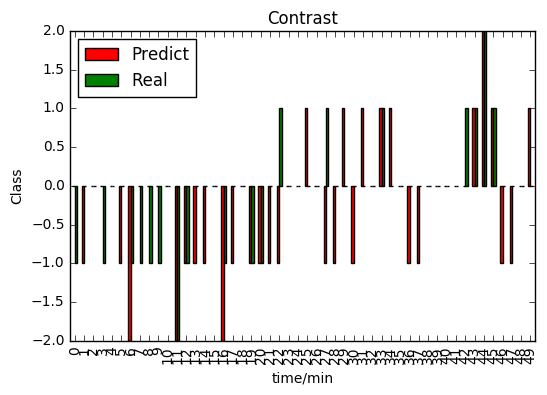

In [44]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-  
# 画出对比图，绿色表示实际值，红色表示预测值
import numpy as np    
import matplotlib.mlab as mlab    
import matplotlib.pyplot as plt    
# import ch
%matplotlib inline

# from pylab import *

# mpl.rcParams['font.sans-serif'] = ['SimHei']
# mpl.rcParams['axes.unicode_minus'] = False
Y1=[]
for i in range(115,165):
    nn_index = sess.run(pred1, feed_dict={xtr1: Xtr3, xte1: Xte3[i,:]})  
    Y1.append(2 - np.argmax(train_label[nn_index]))
Y2=[]
for i in range(115,165):
    Y2.append(2 - np.argmax(test_label[i]))

Y3 = pd.concat([Series(Y1),Series(Y2)],axis=1)
# set_ch()
Y3.columns = ['Predict','Real']
X=range(115,165)
fig = plt.figure()  
Y3.plot(color=['red','green'],kind='bar',use_index=False)  
#plt.bar(X,Y2,0.4,color="red")  
plt.xlabel("time/min")  
plt.ylabel("Class")  
plt.title("Contrast")  

# 进行下一分钟MA5、MA12、MA26、上轨线、下轨线预测的分类（通过调整参数改变预测指标）

In [124]:
# 取前面10000个数据作为训练集
# 前面的数据点因有na值填充，会对准确性造成一定影响，因此从第1000个点开始
train1_data = seq_new_5[1000:11000]
train1_data.shape

(10000, 5, 36)

In [125]:
# 统计最大值和最小值，便于划分区间
data3 = data[1000:11000]
max(data3['boll_down_PRED']),min(data3['boll_down_PRED'])

(3230.1575954099999, 2739.6132079899999)

In [126]:
train1_label = []
for i in data3['boll_down_PRED']:
    if i < 2800:
        train1_label.append([1,0,0,0,0,0,0,0,0,0])   
    elif i < 2850:
        train1_label.append([0,1,0,0,0,0,0,0,0,0])   
    elif i < 2900: 
        train1_label.append([0,0,1,0,0,0,0,0,0,0])   
    elif i < 2950:
        train1_label.append([0,0,0,1,0,0,0,0,0,0])  
    elif i < 3000:
        train1_label.append([0,0,0,0,1,0,0,0,0,0])   
    elif i < 3050:
        train1_label.append([0,0,0,0,0,1,0,0,0,0])  
    elif i < 3100:
        train1_label.append([0,0,0,0,0,0,1,0,0,0])   
    elif i < 3150:
        train1_label.append([0,0,0,0,0,0,0,1,0,0])  
    elif i < 3200:
        train1_label.append([0,0,0,0,0,0,0,0,1,0])   
    else:
        train1_label.append([0,0,0,0,0,0,0,0,0,1])   
    
train1_label = np.array(train1_label)
train1_label.shape

(10000, 10)

In [127]:
train1_label_list = train1_label.tolist()
print train1_label_list.count([1,0,0,0,0,0,0,0,0,0])  
print train1_label_list.count([0,1,0,0,0,0,0,0,0,0]) 
print train1_label_list.count([0,0,1,0,0,0,0,0,0,0]) 
print train1_label_list.count([0,0,0,1,0,0,0,0,0,0])
print train1_label_list.count([0,0,0,0,1,0,0,0,0,0]) 
print train1_label_list.count([0,0,0,0,0,1,0,0,0,0]) 
print train1_label_list.count([0,0,0,0,0,0,1,0,0,0]) 
print train1_label_list.count([0,0,0,0,0,0,0,1,0,0]) 
print train1_label_list.count([0,0,0,0,0,0,0,0,1,0]) 
print train1_label_list.count([0,0,0,0,0,0,0,0,0,1]) 

247
460
1120
834
1283
3082
1317
565
760
332


In [128]:
test1_data = seq_new_5[12000:14000]
test1_data.shape

(2000, 5, 36)

In [129]:
data4 = data[12000:14000]
test1_label = []
for i in data4['boll_down_PRED']:
    if i < 2800:
        test1_label.append([1,0,0,0,0,0,0,0,0,0])   
    elif i < 2850:
        test1_label.append([0,1,0,0,0,0,0,0,0,0])   
    elif i < 2900: 
        test1_label.append([0,0,1,0,0,0,0,0,0,0])   
    elif i < 2950:
        test1_label.append([0,0,0,1,0,0,0,0,0,0])  
    elif i < 3000:
        test1_label.append([0,0,0,0,1,0,0,0,0,0])   
    elif i < 3050:
        test1_label.append([0,0,0,0,0,1,0,0,0,0])  
    elif i < 3100:
        test1_label.append([0,0,0,0,0,0,1,0,0,0])   
    elif i < 3150:
        test1_label.append([0,0,0,0,0,0,0,1,0,0])  
    elif i < 3200:
        test1_label.append([0,0,0,0,0,0,0,0,1,0])   
    else:
        test1_label.append([0,0,0,0,0,0,0,0,0,1])   
        
test1_label = np.array(test1_label)
test1_label.shape

(2000, 10)

In [130]:
test1_label_list = test1_label.tolist()
# 测试集五类样本的数量
print test1_label_list.count([1,0,0,0,0,0,0,0,0,0])  
print test1_label_list.count([0,1,0,0,0,0,0,0,0,0]) 
print test1_label_list.count([0,0,1,0,0,0,0,0,0,0]) 
print test1_label_list.count([0,0,0,1,0,0,0,0,0,0])
print test1_label_list.count([0,0,0,0,1,0,0,0,0,0]) 
print test1_label_list.count([0,0,0,0,0,1,0,0,0,0]) 
print test1_label_list.count([0,0,0,0,0,0,1,0,0,0]) 
print test1_label_list.count([0,0,0,0,0,0,0,1,0,0]) 
print test1_label_list.count([0,0,0,0,0,0,0,0,1,0]) 
print test1_label_list.count([0,0,0,0,0,0,0,0,0,1]) 

0
0
0
0
0
0
79
373
820
728


In [131]:
import random

learning_rate = 0.001 # 学习速率
training_iters = 100000  # 训练总步长
batch_size = 20 # 每小段步长
display_step = 100  # 每隔一百小段显示输出

# 参数设置
n_input = 36 # 特征数量
n_steps = 5 # 时间序列长度
n_hidden = 500 # 隐藏层神经元个数
n_classes = 10 # 分类数量

tf.reset_default_graph()  # 重置流图
# 设置输入输出格式大小
xtr = tf.placeholder("float", [None, n_steps, n_input])
ytr = tf.placeholder("float", [None,n_classes])
# xte = tf.placeholder("float", [None, n_steps, n_input])
# yte = tf.placeholder("float", [None,n_classes])
xtr1 = tf.placeholder("float", [None, n_input*n_steps])  
xte1 = tf.placeholder("float", [n_input*n_steps])
# xte2 = tf.placeholder("float", [None, n_steps, n_input-1])
# 定义权重和偏移量
weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# def pred():
    
def RNN(x, weights, biases):

    # 更改数据集的格式，使其满足RNN网络的输入需求
    # 现在输入格式: (batch_size, n_steps, n_input)
    # 需要的格式: 'n_steps' 个tensor，每个的格式为 (batch_size, n_input)

    # 变换batch_size 和 n_steps的位置
    x = tf.transpose(x, [1, 0, 2])
    # 重新调整格式 (n_steps*batch_size, n_input)
    x = tf.reshape(x, [-1, n_input])
    # 分割成一系列的 'n_steps' 个tensors，每个的格式为 (batch_size, n_input)
    x = tf.split(0, n_steps, x)

    # 定义LSTM神经网络结构
    lstm_cell = rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)
    # 获取输出和状态
    outputs, states = rnn.rnn(lstm_cell, x, dtype=tf.float32)
    # 返回输出
    return tf.matmul(outputs[-1], weights['out']) + biases['out']
# 获取预测值
pred = RNN(xtr, weights, biases)
# train_label = tf.split(0, batch_size, train_label)
# 取下一小段的输入
def next_batch_tr(batch_size):
    step = random.randint(1, len(train1_data)/batch_size)
    next_batch_data = train1_data[(step-1)*batch_size:step*batch_size]
    next_batch_label = train1_label[(step-1)*batch_size:step*batch_size]   
    return next_batch_data, next_batch_label
#         return train_data[(step-1)*batch_size:step*batch_size], train_label[(step-1)*batch_size:step*batch_size]
# def next_batch_te(step, batch_size):
#     return test_data[(step-1)*batch_size:step*batch_size], test_label[(step-1)*batch_size:step*batch_size]

Xtr1 = np.reshape(train1_data, newshape=(-1, n_input*n_steps))  
Xte1 = np.reshape(test1_data, newshape=(-1, n_input*n_steps)) 
Xtr2 = map(map, [float, float], Xtr1)
Xte2 = map(map, [float, float], Xte1)
Xtr3 = np.array(Xtr2)
Xte3 = np.array(Xte2)


In [132]:
# 定义代价函数和最优化方法
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, ytr))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# 评估模型准确率
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(ytr, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# 定义相似度，即预测值与训练值的距离
distance = tf.reduce_sum(tf.abs(tf.add(xtr1, tf.neg(xte1))), reduction_indices=1)  
# 预测值: 获取相似度最高的训练标签，作为预测标签
pred1 = tf.arg_min(distance, 0)  
# 变量初始化
init = tf.initialize_all_variables()

# 创建会话
sess = tf.InteractiveSession()
sess.run(init)
step = 1
    # 一直迭代，直到最大步长
while step * batch_size < training_iters:
    batch_x, batch_y = next_batch_tr(batch_size)
    batch_x = batch_x.reshape((-1, n_steps, n_input))
        # 利用最优化方法调整权值
    sess.run(optimizer, feed_dict={xtr: batch_x, ytr: batch_y})
    if step % display_step == 0:
            # 计算准确率和损失函数
        acc = sess.run(accuracy, feed_dict={xtr: batch_x, ytr: batch_y})
        loss = sess.run(cost, feed_dict={xtr: batch_x, ytr: batch_y})
        # 每隔一定步长显示训练准确率和损失率
        print("Iter " + str(step * batch_size) + ", Minibatch Loss= " +
                "{:.6f}".format(loss) + ", Training Accuracy= " +
                "{:.5f}".format(acc))
    step += 1
print("Optimization Finished!")

    # 计算n个预测值的预测准确率
test_len = 2000
test_data1 = test1_data[:test_len].reshape((-1, n_steps, n_input))
test_label1 = test1_label[:test_len]
print("Testing Accuracy:",
        sess.run(accuracy, feed_dict={xtr: test_data1, ytr: test_label1}))

# for i in range(test_len):  
#         # 索引即为相似度最大的标签值
#     nn_index = sess.run(pred1, feed_dict={xtr1: Xtr3, xte1: Xte3[i,:]})  
#         # 打印出对应的预测标签和实际标签
#     print "Test", i, "Prediction:", np.argmax(train_label[nn_index]), "True Class:", np.argmax(test_label1[i])  

# print "Done!"

Exception AssertionError: AssertionError() in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x7fc1de127190>> ignored


Iter 2000, Minibatch Loss= 0.457351, Training Accuracy= 1.00000
Iter 4000, Minibatch Loss= 1.771903, Training Accuracy= 0.50000
Iter 6000, Minibatch Loss= 1.304004, Training Accuracy= 0.30000
Iter 8000, Minibatch Loss= 0.988512, Training Accuracy= 0.15000
Iter 10000, Minibatch Loss= 1.975686, Training Accuracy= 0.00000
Iter 12000, Minibatch Loss= 0.148012, Training Accuracy= 1.00000
Iter 14000, Minibatch Loss= 0.945994, Training Accuracy= 0.55000
Iter 16000, Minibatch Loss= 0.668397, Training Accuracy= 0.75000
Iter 18000, Minibatch Loss= 0.206071, Training Accuracy= 1.00000
Iter 20000, Minibatch Loss= 0.455516, Training Accuracy= 1.00000
Iter 22000, Minibatch Loss= 0.708812, Training Accuracy= 0.70000
Iter 24000, Minibatch Loss= 0.375262, Training Accuracy= 1.00000
Iter 26000, Minibatch Loss= 0.047513, Training Accuracy= 1.00000
Iter 28000, Minibatch Loss= 0.261796, Training Accuracy= 1.00000
Iter 30000, Minibatch Loss= 0.688061, Training Accuracy= 0.75000
Iter 32000, Minibatch Loss= 0

# 进行趋势持续时间的预测

In [45]:
# 所有测试数据，预测类别与实际类别的对比
for i in range(len(test_data)):  
        # 索引即为相似度最大的标签值
    nn_index = sess.run(pred1, feed_dict={xtr1: Xtr3, xte1: Xte3[i,:]})  
        # 打印出对应的预测标签和实际标签
    print "Test", i, "Prediction:", np.argmax(train_label[nn_index]), "True Class:", np.argmax(test_label[i])  

print "Done!"

Test 0 Prediction: 3 True Class: 2
Test 1 Prediction: 2 True Class: 2
Test 2 Prediction: 3 True Class: 3
Test 3 Prediction: 3 True Class: 3
Test 4 Prediction: 2 True Class: 3
Test 5 Prediction: 3 True Class: 3
Test 6 Prediction: 3 True Class: 2
Test 7 Prediction: 3 True Class: 1
Test 8 Prediction: 1 True Class: 1
Test 9 Prediction: 2 True Class: 2
Test 10 Prediction: 2 True Class: 2
Test 11 Prediction: 2 True Class: 2
Test 12 Prediction: 2 True Class: 2
Test 13 Prediction: 2 True Class: 2
Test 14 Prediction: 2 True Class: 2
Test 15 Prediction: 2 True Class: 2
Test 16 Prediction: 2 True Class: 1
Test 17 Prediction: 3 True Class: 2
Test 18 Prediction: 2 True Class: 3
Test 19 Prediction: 4 True Class: 3
Test 20 Prediction: 3 True Class: 2
Test 21 Prediction: 3 True Class: 1
Test 22 Prediction: 1 True Class: 2
Test 23 Prediction: 3 True Class: 2
Test 24 Prediction: 2 True Class: 2
Test 25 Prediction: 1 True Class: 2
Test 26 Prediction: 1 True Class: 1
Test 27 Prediction: 3 True Class: 1
Te

In [46]:
# 将所有的分类列成数组
pred_class = []
real_class = []
for i in range(len(test_data)):  
        # 索引即为相似度最大的标签值
    nn_index = sess.run(pred1, feed_dict={xtr1: Xtr3, xte1: Xte3[i,:]})  
        # 打印出对应的预测标签和实际标签
    pred_class_eve = np.argmax(train_label[nn_index])
    real_class_eve = np.argmax(test_label[i])
    pred_class.append(pred_class_eve)
    real_class.append(real_class_eve)

pred_class = np.array(pred_class)
real_class = np.array(real_class)


## 1.出现大涨趋势时，持续时间（出现下一个下跌趋势之前的时间）

In [50]:
pred_class1 = pred_class.tolist()
pred_class1

[3,
 2,
 3,
 3,
 2,
 3,
 3,
 3,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 4,
 3,
 1,
 3,
 3,
 2,
 1,
 1,
 3,
 2,
 2,
 2,
 1,
 2,
 3,
 2,
 2,
 2,
 2,
 1,
 3,
 2,
 2,
 3,
 2,
 2,
 1,
 1,
 2,
 3,
 3,
 3,
 2,
 2,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 1,
 1,
 1,
 3,
 1,
 1,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 3,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 3,
 2,
 2,
 2,
 3,
 4,
 2,
 2,
 2,
 2,
 4,
 3,
 3,
 3,
 2,
 3,
 3,
 2,
 3,
 3,
 3,
 1,
 2,
 2,
 1,
 2,
 3,
 3,
 1,
 3,
 1,
 2,
 1,
 1,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 0,
 1,
 3,
 3,
 2,
 1,
 0,
 0,
 1,
 3,
 2,
 3,
 2,
 2,
 2,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 1,
 2,
 1,
 1,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 3,
 2,
 2,
 3,
 3,
 2,
 3,
 2,
 3,
 1,
 3,
 3,
 1,
 1,
 2,
 3,
 3,
 3,
 2,
 3,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,


In [48]:
# 找到所有大涨趋势的时间点
def find_all_index(arr,item):
    return [i for i,a in enumerate(arr) if a==item]
# pred_class1.find(0,0,1999)
highraise_locate = find_all_index(pred_class,0)
highraise_locate = np.array(highraise_locate)
highraise_locate

array([  60,  159,  165,  166,  184,  235,  247,  248,  249,  250,  256,
        385,  386,  390,  427,  428,  536,  810,  821,  835,  985,  987,
       1000, 1072, 1073, 1075, 1168, 1285, 1749, 1767, 1768, 1772, 1781,
       1783, 1866, 1871, 1884, 1888, 1891, 1918, 1937, 1965, 1975, 1976,
       1997, 1998, 1999])

In [50]:
pred_class[390]

0

In [56]:
# 统计每个大涨趋势后30分钟（趋势一般不会超过30分钟）的趋势，如果不下跌就一直累加，直到下一分钟为下跌趋势为止。
# 这就代表了每个大涨趋势的涨持时间
# 很明显最后三个数据点的预测值和实际值相差很大，这很可能是与最后几个独立点难以构成时间序列有关，因此将最后三个数据点去除
count_highraise = []
num_highraise = 1
for i  in highraise_locate[:-3]:
    num_highraise = 1
    for j in range(30):
#     while pred_class[i+j+1] < 2000:
        if pred_class[i+j+1] == 0 or pred_class[i+j+1] == 1 or pred_class[i+j+1] == 2:
            num_highraise += 1
        else:
            break
    count_highraise.append(num_highraise)
count_highraise = np.array(count_highraise)
count_highraise

array([ 6,  2,  3,  2,  3, 17,  5,  4,  3,  2, 18,  8,  7,  3,  3,  2,  3,
        3,  2, 12, 19, 17,  4,  9,  8,  6,  2,  5,  4, 21, 20, 16,  7,  5,
        2,  2,  2,  8,  5,  2,  5,  1, 11, 10])

In [52]:
count_highraise.shape

(44,)

In [53]:
# 输出预测结果
j = 0
print u'预测大涨持续时间：'
for i  in highraise_locate[:-3]:
    print "第", i,"分钟为大涨趋势，直到",count_highraise[j],"分钟后开始下跌"
    j += 1

预测大涨持续时间：
第 60 分钟为大涨趋势，直到 6 分钟后开始下跌
第 159 分钟为大涨趋势，直到 2 分钟后开始下跌
第 165 分钟为大涨趋势，直到 3 分钟后开始下跌
第 166 分钟为大涨趋势，直到 2 分钟后开始下跌
第 184 分钟为大涨趋势，直到 3 分钟后开始下跌
第 235 分钟为大涨趋势，直到 17 分钟后开始下跌
第 247 分钟为大涨趋势，直到 5 分钟后开始下跌
第 248 分钟为大涨趋势，直到 4 分钟后开始下跌
第 249 分钟为大涨趋势，直到 3 分钟后开始下跌
第 250 分钟为大涨趋势，直到 2 分钟后开始下跌
第 256 分钟为大涨趋势，直到 18 分钟后开始下跌
第 385 分钟为大涨趋势，直到 8 分钟后开始下跌
第 386 分钟为大涨趋势，直到 7 分钟后开始下跌
第 390 分钟为大涨趋势，直到 3 分钟后开始下跌
第 427 分钟为大涨趋势，直到 3 分钟后开始下跌
第 428 分钟为大涨趋势，直到 2 分钟后开始下跌
第 536 分钟为大涨趋势，直到 3 分钟后开始下跌
第 810 分钟为大涨趋势，直到 3 分钟后开始下跌
第 821 分钟为大涨趋势，直到 2 分钟后开始下跌
第 835 分钟为大涨趋势，直到 12 分钟后开始下跌
第 985 分钟为大涨趋势，直到 19 分钟后开始下跌
第 987 分钟为大涨趋势，直到 17 分钟后开始下跌
第 1000 分钟为大涨趋势，直到 4 分钟后开始下跌
第 1072 分钟为大涨趋势，直到 9 分钟后开始下跌
第 1073 分钟为大涨趋势，直到 8 分钟后开始下跌
第 1075 分钟为大涨趋势，直到 6 分钟后开始下跌
第 1168 分钟为大涨趋势，直到 2 分钟后开始下跌
第 1285 分钟为大涨趋势，直到 5 分钟后开始下跌
第 1749 分钟为大涨趋势，直到 4 分钟后开始下跌
第 1767 分钟为大涨趋势，直到 21 分钟后开始下跌
第 1768 分钟为大涨趋势，直到 20 分钟后开始下跌
第 1772 分钟为大涨趋势，直到 16 分钟后开始下跌
第 1781 分钟为大涨趋势，直到 7 分钟后开始下跌
第 1783 分钟为大涨趋势，直到 5 分钟后开始下跌
第 1866 分钟为大涨趋势，直到 2 分钟后开始下跌
第 1871 分钟为大涨趋势，直到 2 分钟后开始

In [54]:
# 计算大涨情况下持续时间的准确率
# 因为我们预测的大涨起始时间点本来就有一定错误差，如果严格对比实际值的持续时间长短，准确率会特别低
# 所以选择如下评定准确率方法：在我们预测的涨持时间段内，只要实际值不出现下跌时间点，就判定为该时间段预测正确。
# 准确率就是预测准确的时间段与预测的全部大涨时间段的比值。
j = 0
highraise_acc = 0.
for i in highraise_locate[:-3]:
    j += 1
    isTrue = 1
    for k in range(count_highraise[j-1]):
        if real_class[i+k] == 3 or real_class[i+k] == 4:
            isTrue = 0
            break
    if isTrue == 1:
        highraise_acc += 1./(len(highraise_locate) - 3) 
print "accuary:", highraise_acc
    

accuary: 0.318181818182


## 1.出现大跌趋势时，持续时间（出现下一个上涨趋势之前的时间）

In [57]:
# 找到所有大跌趋势的时间点
def find_all_index(arr,item):
    return [i for i,a in enumerate(arr) if a==item]
# pred_class1.find(0,0,1999)
highdown_locate = find_all_index(pred_class,4)
highdown_locate

[19,
 121,
 126,
 131,
 187,
 632,
 673,
 783,
 957,
 1188,
 1377,
 1466,
 1526,
 1546,
 1699,
 1913,
 1914,
 1915]

In [58]:
pred_class[957]

4

In [59]:
# 统计每个大跌趋势后30分钟（趋势一般不会超过30分钟）的趋势，如果不上涨就一直累加，直到下一分钟为上涨趋势为止。
# 这就代表了每个大跌趋势的跌持时间
count_highdown = []
num_highdown = 1
for i  in highdown_locate:
    num_highdown = 1
    for j in range(30):
#     while pred_class[i+j+1] < 2000:
        if pred_class[i+j+1] == 0 or pred_class[i+j+1] == 3 or pred_class[i+j+1] == 4:
            num_highdown += 1
        else:
            break
    count_highdown.append(num_highdown)
count_highdown = np.array(count_highdown)
count_highdown

array([3, 1, 4, 2, 1, 3, 1, 2, 3, 2, 1, 2, 2, 2, 1, 3, 2, 1])

In [60]:
count_highdown.shape

(18,)

In [61]:
j = 0
print u'预测大跌持续时间：'
for i  in highdown_locate:
    print "第", i,"分钟为大跌趋势，直到",count_highdown[j],"分钟后开始上涨"
    j += 1

预测大跌持续时间：
第 19 分钟为大跌趋势，直到 3 分钟后开始上涨
第 121 分钟为大跌趋势，直到 1 分钟后开始上涨
第 126 分钟为大跌趋势，直到 4 分钟后开始上涨
第 131 分钟为大跌趋势，直到 2 分钟后开始上涨
第 187 分钟为大跌趋势，直到 1 分钟后开始上涨
第 632 分钟为大跌趋势，直到 3 分钟后开始上涨
第 673 分钟为大跌趋势，直到 1 分钟后开始上涨
第 783 分钟为大跌趋势，直到 2 分钟后开始上涨
第 957 分钟为大跌趋势，直到 3 分钟后开始上涨
第 1188 分钟为大跌趋势，直到 2 分钟后开始上涨
第 1377 分钟为大跌趋势，直到 1 分钟后开始上涨
第 1466 分钟为大跌趋势，直到 2 分钟后开始上涨
第 1526 分钟为大跌趋势，直到 2 分钟后开始上涨
第 1546 分钟为大跌趋势，直到 2 分钟后开始上涨
第 1699 分钟为大跌趋势，直到 1 分钟后开始上涨
第 1913 分钟为大跌趋势，直到 3 分钟后开始上涨
第 1914 分钟为大跌趋势，直到 2 分钟后开始上涨
第 1915 分钟为大跌趋势，直到 1 分钟后开始上涨


In [62]:
# 计算大跌情况下持续时间的准确率
# 计算方法与大涨情况相同
j = 0
highdown_acc = 0.
for i in highdown_locate:
    j += 1
    isTrue = 1
    for k in range(count_highdown[j-1]):
        if real_class[i+k] == 0 or real_class[i+k] == 1 :
            isTrue = 0
            break
    if isTrue == 1:
        highdown_acc += 1./(len(highdown_locate)) 
print "accuary:", highdown_acc
    

accuary: 0.833333333333


In [124]:
2./7

0.2857142857142857

# 进行最高价的分类

In [98]:
train1_data = seq_5[2000:22000]
train1_data.shape

(20000, 5, 32)

In [99]:
data3 = data[2000:22000]
train1_label = []
for i in data3['MaxPrice']:
    if i < 3100:
        train1_label.append([1,0,0,0,0,0,0,0,0,0])   # 最高价 < 2800
    elif i < 3110:
        train1_label.append([0,1,0,0,0,0,0,0,0,0])   # 最高价 2800~2900
    elif i < 3120: 
        train1_label.append([0,0,1,0,0,0,0,0,0,0])   # 最高价 2900~3000
    elif i < 3130:
        train1_label.append([0,0,0,1,0,0,0,0,0,0])   # 最高价 3000~3100
    elif i < 3140:
        train1_label.append([0,0,0,0,1,0,0,0,0,0])   # 最高价 3100~3200
    elif i < 3150:
        train1_label.append([0,0,0,0,0,1,0,0,0,0])   # 最高价 3200~3300
    elif i < 3160:
        train1_label.append([0,0,0,0,0,0,1,0,0,0])   # 最高价 3300~3400
    elif i < 3170:
        train1_label.append([0,0,0,0,0,0,0,1,0,0])   # 最高价 3400~3500
    elif i < 3180:
        train1_label.append([0,0,0,0,0,0,0,0,1,0])   # 最高价 3500~3600
    else:
        train1_label.append([0,0,0,0,0,0,0,0,0,1])   # 最高价 > 3600
    
train1_label = np.array(train1_label)
train1_label.shape

(20000, 10)

In [100]:
train1_label_list = train1_label.tolist()
print train1_label_list.count([1,0,0,0,0,0,0,0,0,0])  
print train1_label_list.count([0,1,0,0,0,0,0,0,0,0]) 
print train1_label_list.count([0,0,1,0,0,0,0,0,0,0]) 
print train1_label_list.count([0,0,0,1,0,0,0,0,0,0])
print train1_label_list.count([0,0,0,0,1,0,0,0,0,0]) 
print train1_label_list.count([0,0,0,0,0,1,0,0,0,0]) 
print train1_label_list.count([0,0,0,0,0,0,1,0,0,0]) 
print train1_label_list.count([0,0,0,0,0,0,0,1,0,0]) 
print train1_label_list.count([0,0,0,0,0,0,0,0,1,0]) 
print train1_label_list.count([0,0,0,0,0,0,0,0,0,1]) 

11615
267
421
655
1086
598
403
400
587
3968


In [101]:
test1_data = seq_5[22000:23000]
test1_data.shape

(1000, 5, 32)

In [102]:
data4 = data[22000:23000]
test1_label = []
for i in data4['MaxPrice']:
    if i < 3100:
        test1_label.append([1,0,0,0,0,0,0,0,0,0])   # 最高价 < 2800
    elif i < 3110:
        test1_label.append([0,1,0,0,0,0,0,0,0,0])   # 最高价 2800~2900
    elif i < 3120: 
        test1_label.append([0,0,1,0,0,0,0,0,0,0])   # 最高价 2900~3000
    elif i < 3130:
        test1_label.append([0,0,0,1,0,0,0,0,0,0])   # 最高价 3000~3100
    elif i < 3140:
        test1_label.append([0,0,0,0,1,0,0,0,0,0])   # 最高价 3100~3200
    elif i < 3150:
        test1_label.append([0,0,0,0,0,1,0,0,0,0])   # 最高价 3200~3300
    elif i < 3160:
        test1_label.append([0,0,0,0,0,0,1,0,0,0])   # 最高价 3300~3400
    elif i < 3170:
        test1_label.append([0,0,0,0,0,0,0,1,0,0])   # 最高价 3400~3500
    elif i < 3180:
        test1_label.append([0,0,0,0,0,0,0,0,1,0])   # 最高价 3500~3600
    else:
        test1_label.append([0,0,0,0,0,0,0,0,0,1])   # 最高价 > 3600
    
test1_label = np.array(test1_label)
test1_label.shape

(1000, 10)

In [69]:
max(data4['MaxPrice']),min(data4['MaxPrice'])

(3182.8000000000002, 3043.8000000000002)

In [103]:
test1_label_list = test1_label.tolist()
# 测试集五类样本的数量
print test1_label_list.count([1,0,0,0,0,0,0,0,0,0])  
print test1_label_list.count([0,1,0,0,0,0,0,0,0,0]) 
print test1_label_list.count([0,0,1,0,0,0,0,0,0,0]) 
print test1_label_list.count([0,0,0,1,0,0,0,0,0,0])
print test1_label_list.count([0,0,0,0,1,0,0,0,0,0]) 
print test1_label_list.count([0,0,0,0,0,1,0,0,0,0]) 
print test1_label_list.count([0,0,0,0,0,0,1,0,0,0]) 
print test1_label_list.count([0,0,0,0,0,0,0,1,0,0]) 
print test1_label_list.count([0,0,0,0,0,0,0,0,1,0]) 
print test1_label_list.count([0,0,0,0,0,0,0,0,0,1]) 

0
0
5
7
234
162
386
157
42
7


In [110]:
learning_rate = 0.001 # 学习速率
training_iters = 20000  # 训练总步长
batch_size = 200  # 每小段步长
display_step = 10  # 每隔十小段显示输出

# 参数设置
n_input = 32 # 特征数量
n_steps = 5 # 时间序列长度
n_hidden = 500 # 隐藏层神经元个数
n_classes = 10 # 分类数量

tf.reset_default_graph()  # 重置流图
# 设置输入输出格式大小
xtr = tf.placeholder("float", [None, n_steps, n_input])
ytr = tf.placeholder("float", [None,n_classes])
# xte = tf.placeholder("float", [None, n_steps, n_input])
# yte = tf.placeholder("float", [None,n_classes])
xtr1 = tf.placeholder("float", [None, n_input*n_steps])  
xte1 = tf.placeholder("float", [n_input*n_steps])  
# 定义权重和偏移量
weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# def pred():
    
def RNN(x, weights, biases):

    # 更改数据集的格式，使其满足RNN网络的输入需求
    # 现在输入格式: (batch_size, n_steps, n_input)
    # 需要的格式: 'n_steps' 个tensor，每个的格式为 (batch_size, n_input)

    # 变换batch_size 和 n_steps的位置
    x = tf.transpose(x, [1, 0, 2])
    # 重新调整格式 (n_steps*batch_size, n_input)
    x = tf.reshape(x, [-1, n_input])
    # 分割成一系列的 'n_steps' 个tensors，每个的格式为 (batch_size, n_input)
    x = tf.split(0, n_steps, x)

    # 定义LSTM神经网络结构
    lstm_cell = rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)
    # 获取输出和状态
    outputs, states = rnn.rnn(lstm_cell, x, dtype=tf.float32)
    # 返回输出
    return tf.matmul(outputs[-1], weights['out']) + biases['out']
# 获取预测值
pred = RNN(xtr, weights, biases)
# train_label = tf.split(0, batch_size, train_label)
# 取下一小段的输入
def next_batch_tr(step, batch_size):
    return train1_data[(step-1)*batch_size:step*batch_size], train1_label[(step-1)*batch_size:step*batch_size]
def next_batch_te(step, batch_size):
    return test1_data[(step-1)*batch_size:step*batch_size], test1_label[(step-1)*batch_size:step*batch_size]

Xtr1 = np.reshape(train1_data, newshape=(-1, n_input*n_steps))  
Xte1 = np.reshape(test1_data, newshape=(-1, n_input*n_steps)) 
Xtr2 = map(map, [float, float], Xtr1)
Xte2 = map(map, [float, float], Xte1)
Xtr3 = np.array(Xtr2)
Xte3 = np.array(Xte2)


In [111]:
# 定义代价函数和最优化方法
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, ytr))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# 评估模型准确率
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(ytr, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# 定义相似度，即预测值与训练值的距离
distance = tf.reduce_sum(tf.abs(tf.add(xtr1, tf.neg(xte1))), reduction_indices=1)  
# 预测值: 获取相似度最高的训练标签，作为预测标签
pred1 = tf.arg_min(distance, 0)  
accuracy1 = 0.  
# 变量初始化
init = tf.initialize_all_variables()

# 创建会话
sess = tf.InteractiveSession()
sess.run(init)
step = 1
    # 一直迭代，直到最大步长
while step * batch_size < training_iters:
    batch_x, batch_y = next_batch_tr(step, batch_size)
    batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        # 利用最优化方法调整权值
    sess.run(optimizer, feed_dict={xtr: batch_x, ytr: batch_y})
    if step % display_step == 0:
            # 计算准确率和损失函数
        acc = sess.run(accuracy, feed_dict={xtr: batch_x, ytr: batch_y})
        loss = sess.run(cost, feed_dict={xtr: batch_x, ytr: batch_y})
        # 每隔一定步长显示训练准确率和损失率
#         print("Iter " + str(step * batch_size) + ", Minibatch Loss= " +
#                 "{:.6f}".format(loss) + ", Training Accuracy= " +
#                 "{:.5f}".format(acc))
    step += 1
print("Optimization Finished!")

    # 计算n个预测值的预测准确率
test_len = 1000
test1_data = test1_data[:test_len].reshape((-1, n_steps, n_input))
test1_label = test1_label[:test_len]
# print("Testing Accuracy:",
#         sess.run(accuracy, feed_dict={xtr: test1_data, ytr: test1_label}))

for i in range(test_len):  
        # 索引即为相似度最大的标签值
    nn_index = sess.run(pred1, feed_dict={xtr1: Xtr3, xte1: Xte3[i,:]})  
        # 打印出对应的预测标签和实际标签
    print "Test", i, "Prediction:", np.argmax(train1_label[nn_index]), "True Class:", np.argmax(test1_label[i])  
      
    if np.argmax(train1_label[nn_index]) == np.argmax(test1_label[i]):  
        accuracy1 += 1./test_len 
print "Done!"  
print "Accuracy:", accuracy1  


Exception AssertionError: AssertionError() in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x7f7b282ed710>> ignored


Optimization Finished!
Test 0 Prediction: 4 True Class: 4
Test 1 Prediction: 4 True Class: 4
Test 2 Prediction: 4 True Class: 4
Test 3 Prediction: 4 True Class: 4
Test 4 Prediction: 4 True Class: 4
Test 5 Prediction: 4 True Class: 4
Test 6 Prediction: 4 True Class: 4
Test 7 Prediction: 4 True Class: 4
Test 8 Prediction: 4 True Class: 4
Test 9 Prediction: 4 True Class: 4
Test 10 Prediction: 4 True Class: 4
Test 11 Prediction: 4 True Class: 4
Test 12 Prediction: 4 True Class: 4
Test 13 Prediction: 4 True Class: 4
Test 14 Prediction: 4 True Class: 4
Test 15 Prediction: 4 True Class: 4
Test 16 Prediction: 4 True Class: 4
Test 17 Prediction: 5 True Class: 4
Test 18 Prediction: 4 True Class: 4
Test 19 Prediction: 4 True Class: 4
Test 20 Prediction: 4 True Class: 4
Test 21 Prediction: 4 True Class: 4
Test 22 Prediction: 4 True Class: 4
Test 23 Prediction: 4 True Class: 4
Test 24 Prediction: 4 True Class: 4
Test 25 Prediction: 4 True Class: 4
Test 26 Prediction: 4 True Class: 4
Test 27 Predict

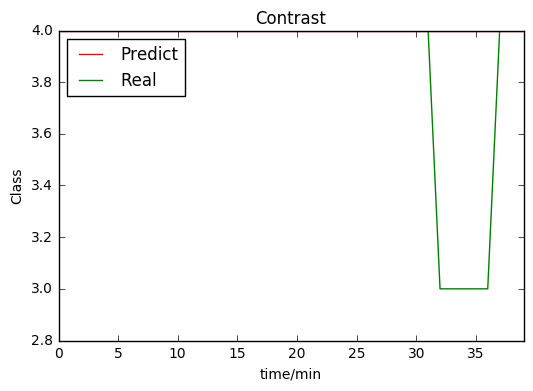

In [118]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-  
# 画出对比图，绿色表示实际值，红色表示预测值
import numpy as np    
import matplotlib.mlab as mlab    
import matplotlib.pyplot as plt    
# import ch
%matplotlib inline

# from pylab import *

# mpl.rcParams['font.sans-serif'] = ['SimHei']
# mpl.rcParams['axes.unicode_minus'] = False
Y1=[]
for i in range(60,100):
    nn_index = sess.run(pred1, feed_dict={xtr1: Xtr3, xte1: Xte3[i,:]})  
    Y1.append(np.argmax(train1_label[nn_index]))
Y2=[]
for i in range(60,100):
    Y2.append(np.argmax(test1_label[i]))

Y3 = pd.concat([Series(Y1),Series(Y2)],axis=1)
# set_ch()
Y3.columns = ['Predict','Real']
X=range(60,100) 
fig = plt.figure()  
Y3.plot(color=['red','green'],kind='line',use_index=False)  
#plt.bar(X,Y2,0.4,color="red")  
plt.xlabel("time/min")  
plt.ylabel("Class")  
plt.title("Contrast")  